In [2]:
from collections import defaultdict
from typing import Dict, List, Any, FrozenSet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy.typing as npt

from IPython.display import display
from scipy.stats import spearmanr

In [3]:
# path = "../results/test_layerwise/EleutherAI-pythia-6.9b_EleutherAI-pythia-6.9b_similarity.parquet"
# path = "../results/test_layerwise/meta-llama-Llama-2-7b-hf_meta-llama-Llama-2-7b-hf_similarity.parquet"
# path = "../results/test_layerwise/EleutherAI-pythia-70m-deduped_EleutherAI-pythia-70m-deduped_similarity.parquet"
# path = "../results/test_layerwise/multibert-0-mnli_multibert-0-mnli_similarity__old.parquet"
# df = pd.read_parquet(path)
# print(len(df))
# df.head()

2197


,layer1,layer2,score,model1,model2,dataset,split,measure,strategy
0,0,0,NaN,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,glue,test_matched,Pipeline(center_columns+normalize_matrix_norm+...,"[0, 0]"
1,0,1,1.414229,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,glue,test_matched,Pipeline(center_columns+normalize_matrix_norm+...,"[0, 0]"
2,0,2,1.414229,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,glue,test_matched,Pipeline(center_columns+normalize_matrix_norm+...,"[0, 0]"
3,0,3,1.414229,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,glue,test_matched,Pipeline(center_columns+normalize_matrix_norm+...,"[0, 0]"
4,0,4,1.414230,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,/root/LLM-comparison/outputs/hf_ft_tutorial/ch...,glue,test_matched,Pipeline(center_columns+normalize_matrix_norm+...,"[0, 0]"


,median,mean,min,max
measure,,,,
Aligned Cosine Similarity,1.000000,0.998939,0.987879,1.0
Jaccard Similarity,1.000000,0.998258,0.983333,1.0
Orthogonal Procrustes,1.000000,0.996916,0.976190,1.0
Rank Similarity,1.000000,0.996310,0.975758,1.0
"RSA (Euc,Spearman)",1.000000,0.995725,0.976190,1.0
Joint Rank-Jaccard Similarity,1.000000,0.995476,0.963636,1.0
Norm of RSM Difference (Euc),1.000000,0.988701,0.928571,1.0
Distance Correlation,1.000000,0.987273,0.900000,1.0
CKA,1.000000,0.952273,0.500000,1.0


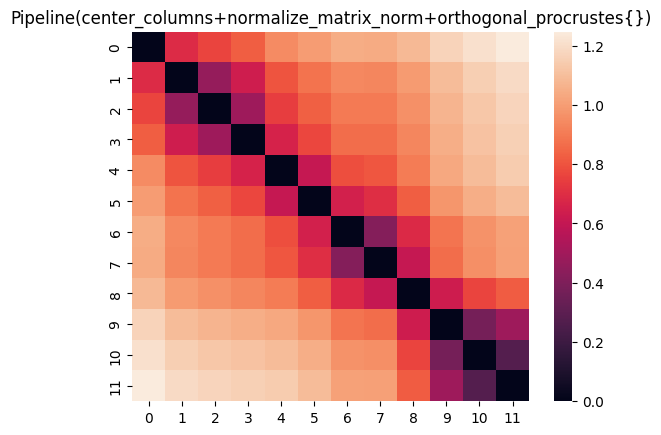

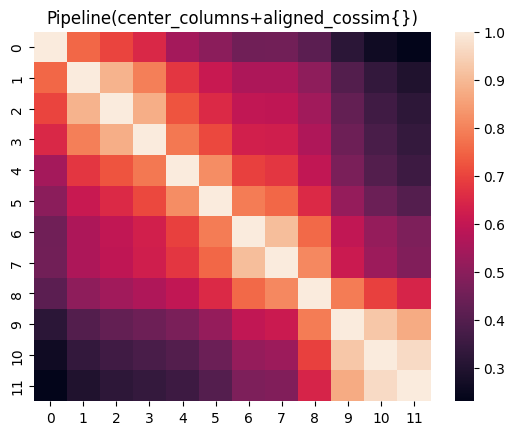

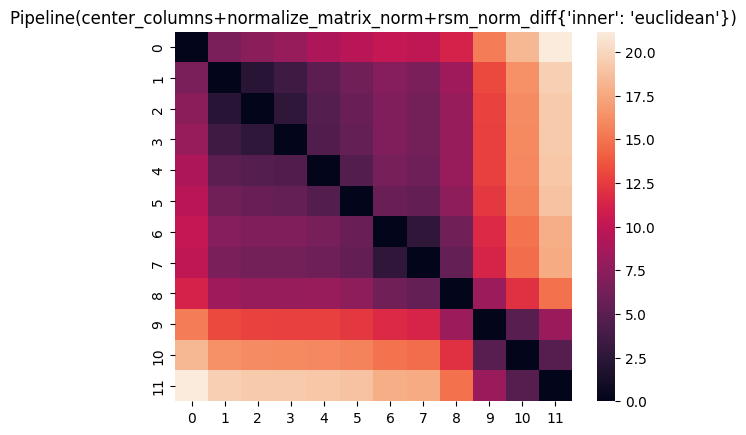

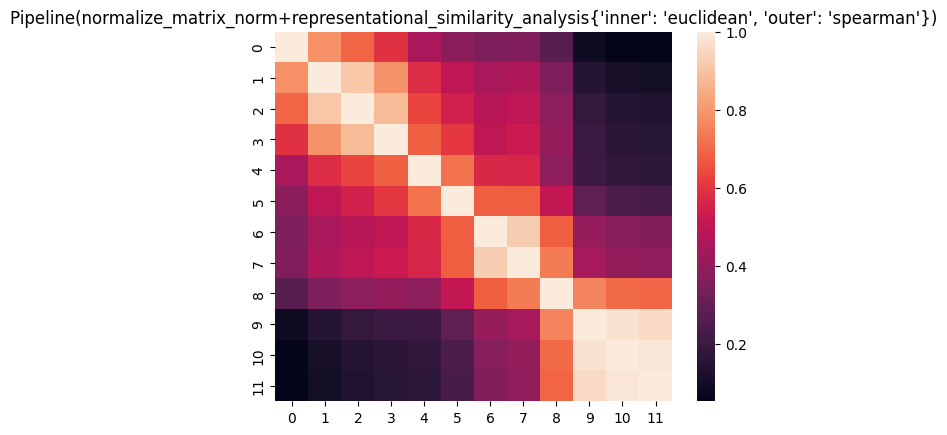

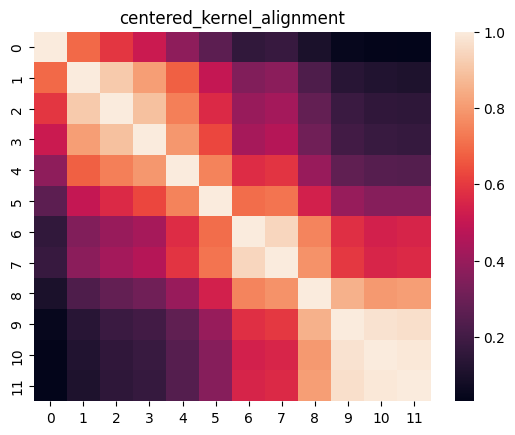

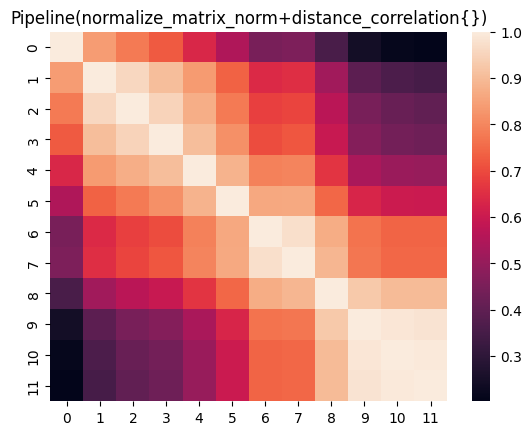

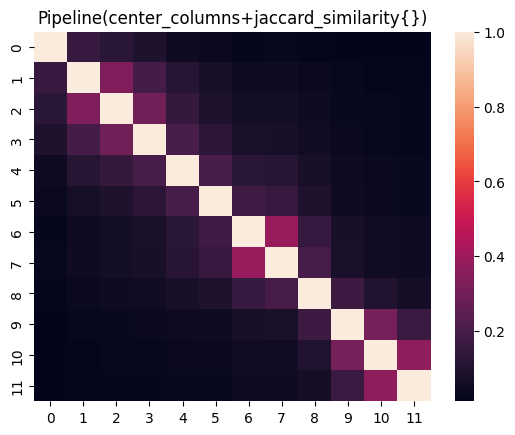

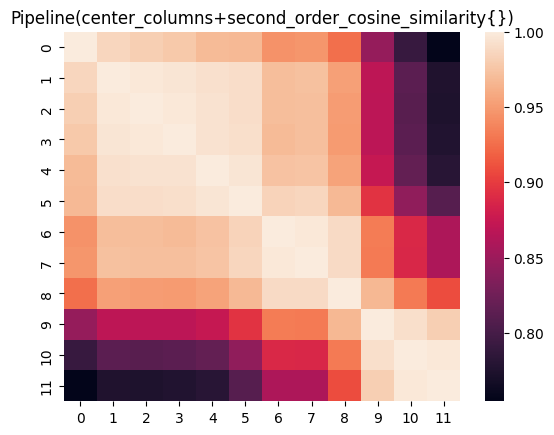

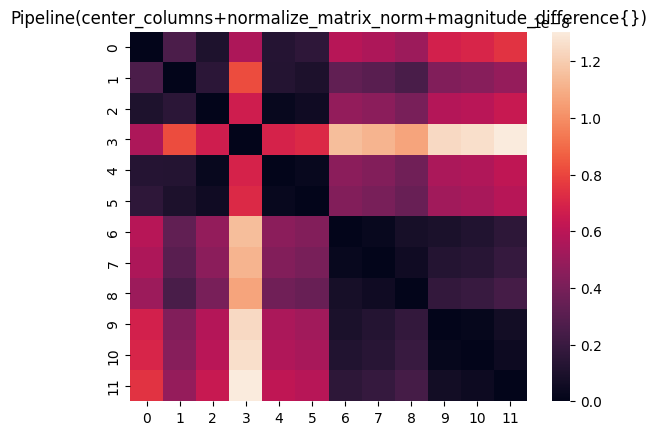

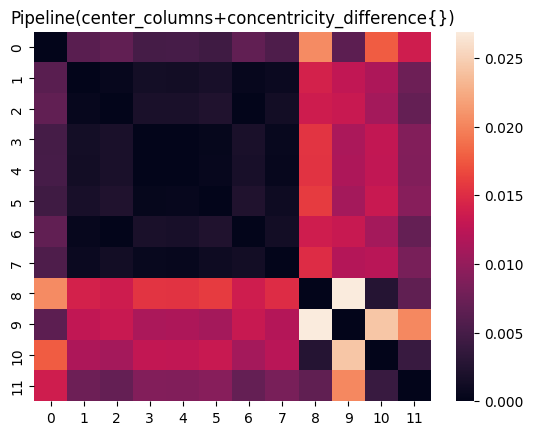

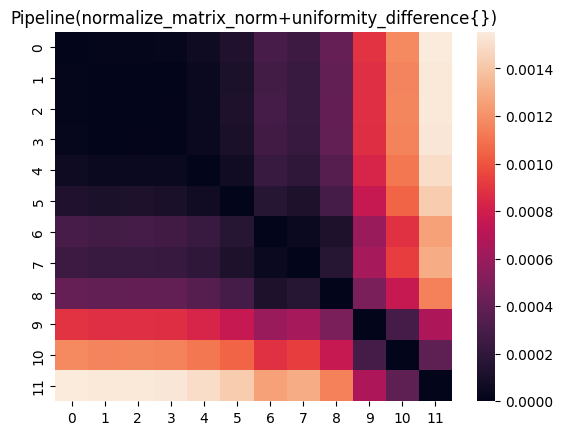

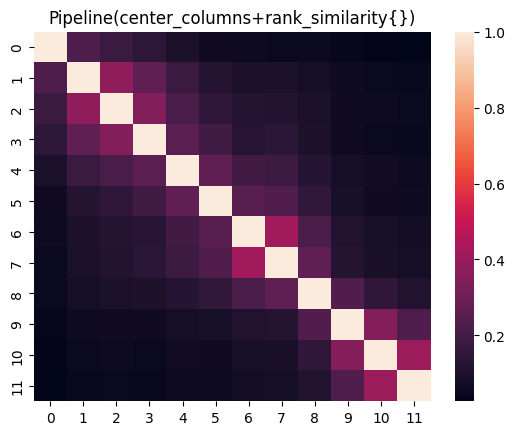

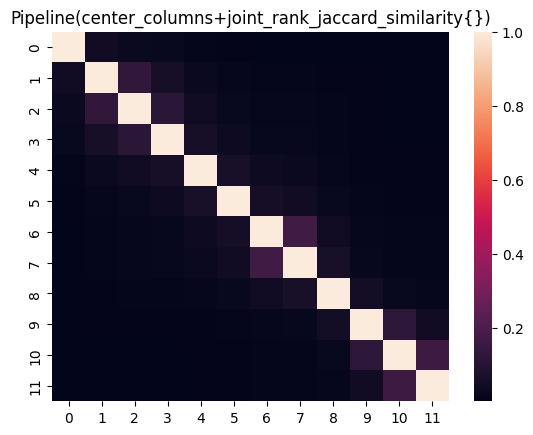

In [4]:
def depth_sim_correlation(
    values: npt.NDArray, is_distance: bool
) -> Dict[str, List[Any]]:
    n_layers1, n_layers2 = values.shape
    assert (
        n_layers1 == n_layers2
    ), "Number of layers does not match. Only compare a model to itself!"
    results = defaultdict(list)

    layer_idxs = np.arange(n_layers2)
    for anchor_layer in range(n_layers1):
        layer_diff = abs(layer_idxs - anchor_layer)

        # check in two directions:
        # a) the layers before the anchor_layer,
        scores = values[anchor_layer, :anchor_layer]
        corr_pre = spearmanr(scores, layer_diff[:anchor_layer])
        corr_pre = corr_pre.statistic if is_distance else -1 * corr_pre.statistic  # type: ignore
        # b) the layers after the anchor_layer
        scores = values[anchor_layer, anchor_layer + 1 :]
        corr_post = spearmanr(scores, layer_diff[anchor_layer + 1 :])
        corr_post = corr_post.statistic if is_distance else -1 * corr_post.statistic  # type: ignore

        results["anchor"].extend([anchor_layer] * 2)
        results["corr"].append(corr_pre)
        results["pre/post"].append("pre")
        results["corr"].append(corr_post)
        results["pre/post"].append("post")
    return results


def table_layerdist_similarity_correlation(
    path: str,
    plot: bool = True,
    return_corrs: bool = False,
    layers_to_remove: FrozenSet[int] = frozenset((0,)),
):
    df = pd.read_parquet(path)

    MEASURES = df.measure.unique()
    DISTANCE_MEASURES = set(
        (
            "Pipeline(center_columns+normalize_matrix_norm+orthogonal_procrustes{})",
            "Pipeline(center_columns+normalize_matrix_norm+orthogonal_angular_shape_metric{})",
            "Pipeline(center_columns+normalize_matrix_norm+rsm_norm_diff{'inner': 'euclidean'})",
            "Pipeline(center_columns+normalize_matrix_norm+magnitude_difference{})",
            "Pipeline(center_columns+concentricity_difference{})",
            "Pipeline(normalize_matrix_norm+uniformity_difference{})",
        )
    )
    LONG_TO_SHORT_NAMES = {
        "Pipeline(center_columns+normalize_matrix_norm+orthogonal_angular_shape_metric{})": "Angular Shape Metric",
        "Pipeline(center_columns+normalize_matrix_norm+orthogonal_procrustes{})": "Orthogonal Procrustes",
        "Pipeline(center_columns+aligned_cossim{})": "Aligned Cosine Similarity",
        "Pipeline(center_columns+jaccard_similarity{})": "Jaccard Similarity",
        "Pipeline(center_columns+joint_rank_jaccard_similarity{})": "Joint Rank-Jaccard Similarity",
        "Pipeline(normalize_matrix_norm+representational_similarity_analysis{'inner': 'euclidean', 'outer': 'spearman'})": "RSA (Euc,Spearman)",
        "Pipeline(center_columns+normalize_matrix_norm+magnitude_difference{})": "Magnitude Difference",
        "Pipeline(center_columns+normalize_matrix_norm+rsm_norm_diff{'inner': 'euclidean'})": "Norm of RSM Difference (Euc)",
        "Pipeline(center_columns+rank_similarity{})": "Rank Similarity",
        "Pipeline(normalize_matrix_norm+distance_correlation{})": "Distance Correlation",
        "centered_kernel_alignment": "CKA",
        "Pipeline(normalize_matrix_norm+uniformity_difference{})": "Uniformity Difference",
        "Pipeline(center_columns+concentricity_difference{})": "Concentricity Difference",
        "Pipeline(center_columns+second_order_cosine_similarity{})": "Second Order Cosine Similarity",
    }

    # Filter out all comparisons with the embedding layer. These representations are context independent, which means whole
    # representation matrix is static here.
    # If we compared the representations for all tokens, I guess we could leave it in. But since we compare only the
    # representations of token 0 ([CLS]), mean centering actually leads to a matrix of zeros, which breaks some
    # preprocessing steps and measures.
    df = df.loc[
        ~(df.layer1.isin(layers_to_remove) | df.layer2.isin(layers_to_remove)), :
    ]

    # Now we compute the correlation between distance from the current layer (the anchor layer) and the similarity score.
    corrs = pd.DataFrame()
    for measure in MEASURES:
        # bring data into correct form
        data = df.loc[df.measure == measure].copy()
        pivot = pd.pivot_table(
            data, values="score", index=["layer1"], columns=["layer2"]
        )
        values = pivot.values
        if measure in DISTANCE_MEASURES:
            values[np.diag_indices(values.shape[0])] = 0
        else:
            values[np.diag_indices(values.shape[0])] = 1

        # measure correlation and collect results
        results = depth_sim_correlation(values, measure in DISTANCE_MEASURES)
        results = pd.DataFrame.from_dict(results)
        results.loc[:, "measure"] = measure
        corrs = pd.concat((corrs, results), axis=0)

        if plot:
            # plot heatmaps for visualization of pairwise similarity between layers
            fig, ax = plt.subplots(1, 1, squeeze=True)
            sns.heatmap(pivot.values, ax=ax)
            ax.set_title(measure)
    corrs = corrs.reset_index(drop=True)

    # Aggregate results into a table for the paper
    data = corrs.dropna(axis=0)  # correlation coefficient is defined in all scenarios
    data = data.groupby(["measure"])["corr"].agg([np.median, np.mean, np.min, np.max])
    data = data.sort_values(by=["mean", "median"], ascending=False)
    data.index = data.index.map(LONG_TO_SHORT_NAMES)
    display(data)

    if return_corrs:
        return data, corrs
    return data

    display(data.sort_values(by=["median", "mean"], ascending=False))


# path = "../results/test_layerwise/multibert-0-mnli_multibert-0-mnli_similarity.parquet"
# data = table_layerdist_similarity_correlation(path, plot=True)
# path = "../results/test_layerwise/multibert-0-mnli_multibert-0-mnli_similarity__old.parquet"
# data = table_layerdist_similarity_correlation(path, plot=True)

path = "../results/test_layerwise/multibert-0-sst2_multibert-0-sst2_similarity.parquet"
data = table_layerdist_similarity_correlation(path, plot=True)

# table_layerdist_similarity_correlation(path, plot=False, layers_to_remove=frozenset())

In [7]:
def latex_format(data: pd.DataFrame):
    s = data.to_latex(
        columns=["median", "mean"],
        header=["Median", "Mean"],
        column_format="lcc",
        float_format="{:0.2f}".format,
        escape=False,
        multicolumn_format="c",
        index_names=False,
    )
    return s.replace(" & Median & Mean", "Measure & Median & Mean")

# print(data)
assert isinstance(data, pd.DataFrame)
print(latex_format(data))

\begin{tabular}{lcc}
\toprule
Measure & Median & Mean \\
\midrule
Aligned Cosine Similarity & 1.00 & 1.00 \\
Jaccard Similarity & 1.00 & 1.00 \\
Orthogonal Procrustes & 1.00 & 1.00 \\
Rank Similarity & 1.00 & 1.00 \\
RSA (Euc,Spearman) & 1.00 & 1.00 \\
Joint Rank-Jaccard Similarity & 1.00 & 1.00 \\
Norm of RSM Difference (Euc) & 1.00 & 0.99 \\
Distance Correlation & 1.00 & 0.99 \\
CKA & 1.00 & 0.95 \\
Second Order Cosine Similarity & 0.98 & 0.95 \\
Uniformity Difference & 0.98 & 0.94 \\
Magnitude Difference & 0.74 & 0.53 \\
Concentricity Difference & 0.38 & 0.24 \\
\bottomrule
\end{tabular}



In [6]:
# for measure in MEASURES:
#     data = corrs.dropna(axis=0)
#     data = data.loc[data.measure==measure, :]
#     plt.figure()
#     plt.hist(data["corr"].values, label=measure)
#     plt.legend()